In [12]:
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib.gridspec import GridSpec as GS
import matplotlib.pyplot as plt
from matplotlib import cm
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import scipy as sci
from scipy.integrate import odeint, solve_ivp
import random
import time

#defining the LLG
def func(t, m,h,gamma,alpha):
     dm=-gamma*(np.cross(m,h)-alpha*np.cross(m,-gamma*np.cross(m,h)))
     
     return dm
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device=torch.device('cpu')

In [13]:
#defining number of spins
dim=3
#defining the interaction matrix between spins
mat=np.array([[0,1,0],[1,0,1],[0,1,0]],dtype='float') #linear
def func(t, m,h,gamma,alpha,J,mat):
    m=m.reshape(dim,3)
    dm=np.ones_like(m)
    for i in range(dim):
        dm[i]=-gamma*(np.cross(m[i],h+J*np.matmul(mat[i],m))-alpha*np.cross(m[i],-gamma*np.cross(m[i],h+J*np.matmul(mat[i],m))))
    return dm.flatten()
#define inital magentisation
m0=[0,np.sin((1/180)*np.pi),np.cos((1/180)*np.pi)] 
m1=[0,-np.sin((1/180)*np.pi),-np.cos((1/180)*np.pi)]
m=np.array([m0,m1,m0]).flatten()
#define parameters
gamma=-1.760  #*10^11 for actual value
alpha=0.05
h=(0,0,-1)
J=0.3
p=(h,gamma,alpha,J,mat)
t_ = np.linspace(0,65.,num=1000)
dt=t_[1]-t_[0]
result_odeint = odeint(func, m, t_,p, tfirst=True).astype(np.float32)

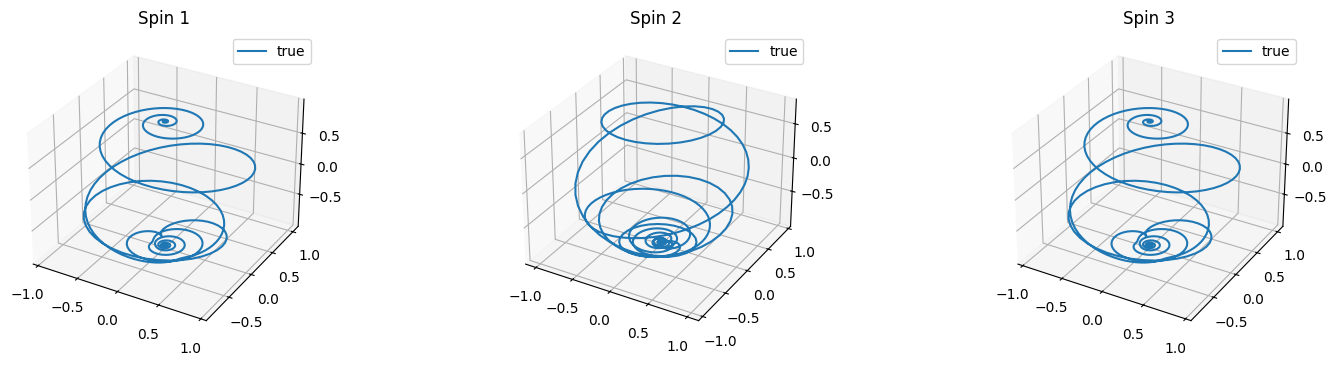

In [14]:
#plot numerical solutions
fig=plt.figure(figsize=(18, 4))
for i in range(dim):
    plt.subplot(1,dim,i+1,projection='3d')
    plt.plot(result_odeint[:,3*i],result_odeint[:,3*i+1],result_odeint[:,3*i+2],label='true')
    plt.title(str("Spin "+str(i+1)))
    plt.legend()
# plt.tight_layout()
plt.show()

In [15]:
#define LSTM model
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=dim*3, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, dim*3)
        self.hidden=self.init_hidden(dim*3*3)
    def init_hidden(self,size):
        return (torch.autograd.Variable(torch.zeros(1, size, 50)).to(device),
                torch.autograd.Variable(torch.zeros(1, size, 50)).to(device))
    def forward(self, x):
        x, self.hidden = self.lstm(x,self.hidden)
        x = self.linear(x)
        return x

In [16]:
#prepare training and test datasets
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data.dataloader import default_collate

timeseries = result_odeint.astype('float32')
# train-test split for time series
train_size = int(len(timeseries) * 0.5)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device) 
y_test=y_test.to(device)

In [17]:
#define loss(pde +norm)
def pde_loss(x,m,p,dt):
    (h_,gamma,alpha,J,mat)=p
    pde_loss=torch.zeros(dim,3)
    norm_loss=torch.zeros(dim)
    m=m.reshape(dim,3)
    x=x.reshape(dim,3)
    mat=torch.tensor(mat,dtype=torch.float).to(device)
    h=torch.tensor([h_], dtype=torch.float).reshape(3).to(device)

    
    for i in range(dim):
        pde_loss[i]=(m[i]-x[i])/dt+gamma*(torch.linalg.cross(m[i],h+J*torch.matmul(mat[i],m))-alpha*torch.linalg.cross(m[i],-gamma*torch.linalg.cross(m[i],h+J*torch.matmul(mat[i],m))))
        norm_loss[i]=(torch.tensor(1.)-torch.linalg.norm(m[i]))**2

    pde_loss=torch.linalg.norm(pde_loss)
    return torch.sum(pde_loss+norm_loss)
        

In [48]:
#define plotting
xyz=("x",'y','z')
def plot(model):
    model.to(device)
    model.eval()
    with torch.no_grad():
        # shift train predictions for plotting
        train_plot = np.ones_like(timeseries) * np.nan
        model.hidden = model.init_hidden(len(X_train))
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, :]
        model.hidden = model.init_hidden(len(X_train))
        train_plot[lookback:train_size] = model(X_train)[:, -1, :].cpu().detach()
        # shift test predictions for plotting
        test_plot = np.ones_like(timeseries) * np.nan
        model.hidden = model.init_hidden(len(X_test))
        test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :].cpu().detach()
        plt.figure(figsize=(18, 12))
        for j in range(dim):
            for i in range(3):
                plt.subplot(dim,3,3*j+i+1)
            
                plt.plot(timeseries[:,i],label='true')
                plt.plot(train_plot[:,i], c='r',label='training')
                plt.plot(test_plot[:,i], c='g',label='prediction')
                plt.legend()
                plt.title("Spin "+str(j+1)+", "+str(xyz[i]))
        # plt.tight_layout()
        plt.show()
        figure = plt.figure(figsize=(18, 12))

        for j in range(dim):
            bx = figure.add_subplot(dim,3,j+1, projection='3d')
            bx.plot(timeseries[:,3*j],timeseries[:,3*j+1],timeseries[:,3*j+2],label='true')
            bx.plot(train_plot[:,3*j],train_plot[:,3*j+1],train_plot[:,3*j+2], c='r',label='training')
            bx.plot(test_plot[:,3*j],test_plot[:,3*j+1],test_plot[:,3*j+2], c='g',label='prediction')
            bx.legend()
            plt.title("Spin "+str(j+1))
        plt.show()
# plt.tight_layout()

In [37]:
#initialize model
model = AirModel()
model=model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=3,drop_last=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
n_epochs = 200 #Spcify number of epochs
loss_list=[]
for epoch in range(n_epochs):
    model.train()
    
    hidden=model.hidden
    list=[]
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        model.hidden = model.init_hidden(3)
        
        y_pred= model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        list.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        model.hidden = model.init_hidden(3)
        m0=model(X_train[-3:])
        m0=m0.detach()
    model.train()
    list1=[]
    for i in range(len(X_test)):
        model.hidden=model.init_hidden(3)
        # list.append(m0[-1].cpu().detach().numpy())
        optimizer.zero_grad()
        
        m0= torch.cat((m0,model(m0)[-1].reshape([1,3,3*dim])), 0)
        loss=loss_fn(pde_loss(m0[-1,-2],m0[-1,-1],p,dt),torch.tensor(0.).to(device))
        list1.append(loss.cpu().detach().numpy())
        m0=m0[1:]
        m0=m0.detach()
        loss.backward()
        optimizer.step()
    # Validation
    loss_list.append(np.sum(np.array(list))+np.sum(np.array(list1))/(len(list1)+len(list)))
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        model.hidden = model.init_hidden(len(X_train))
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu().detach())
        model.hidden = model.init_hidden(len(X_test))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu().detach())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f,loss %.4f" % (epoch, train_rmse, test_rmse,loss_list[-1]))
print("Epoch %d: train RMSE %.4f, test RMSE %.4f,loss %.4f" % (epoch, train_rmse, test_rmse,loss_list[-1]))

Epoch 0: train RMSE 0.4469, test RMSE 0.4322,loss 41.6433
Epoch 50: train RMSE 0.0909, test RMSE 0.0352,loss 1.1558
Epoch 100: train RMSE 0.0488, test RMSE 0.0114,loss 0.3149
Epoch 150: train RMSE 0.0560, test RMSE 0.0118,loss 0.2088
Epoch 199: train RMSE 0.0560, test RMSE 0.0118,loss 0.4243


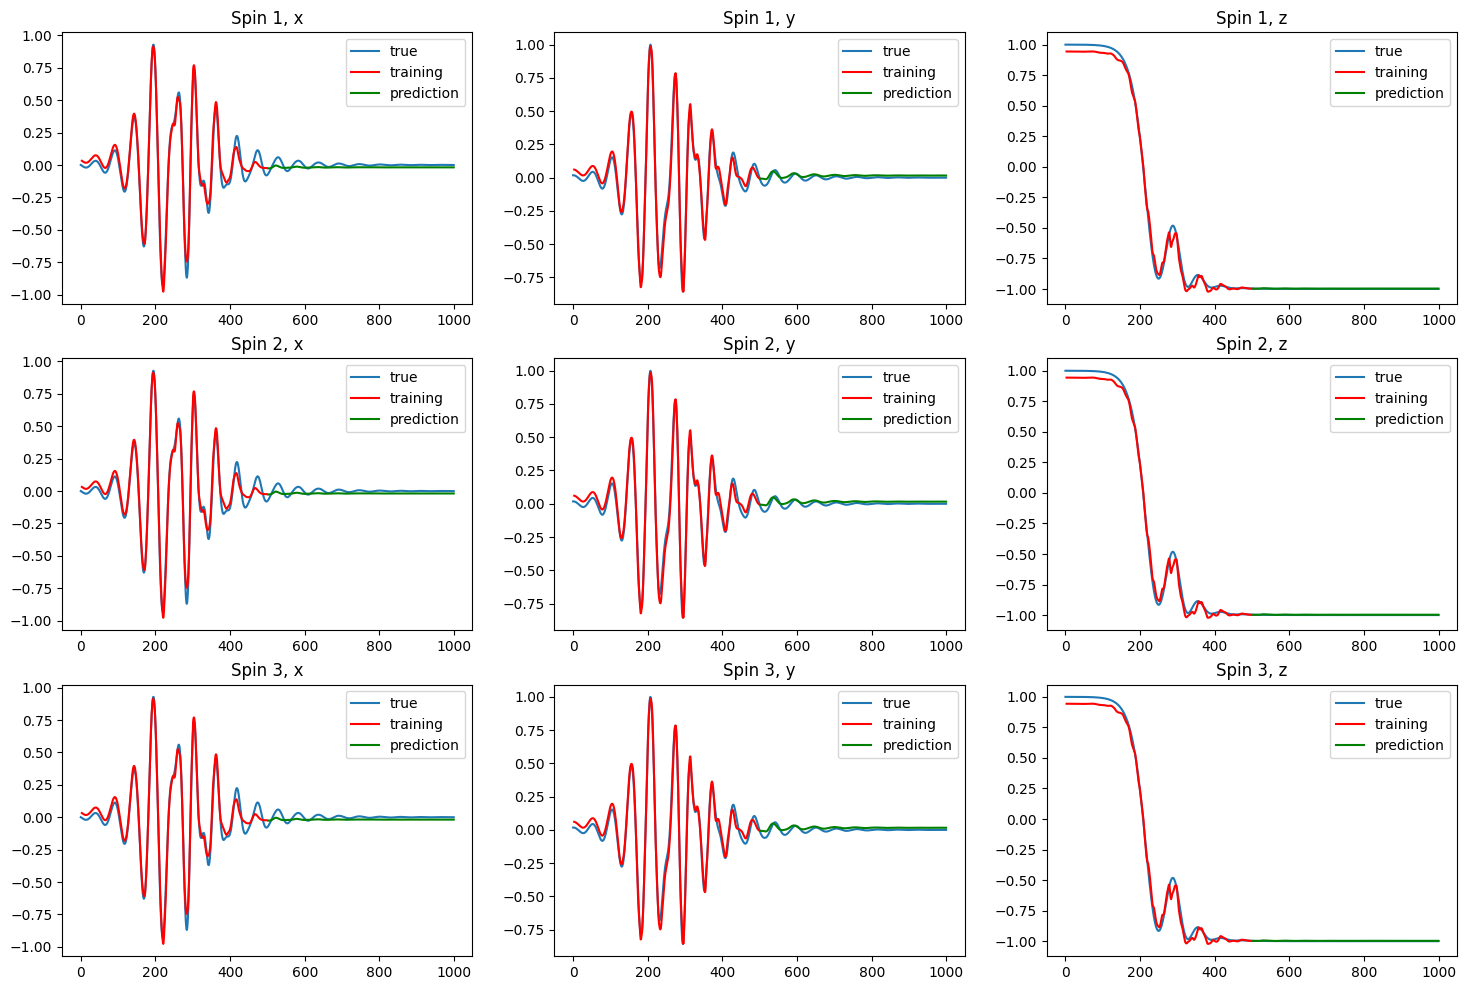

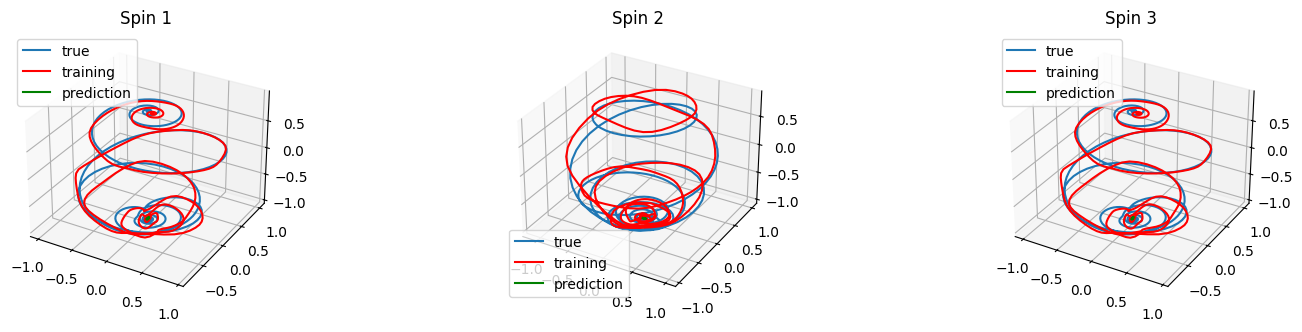

In [49]:
plot(model)

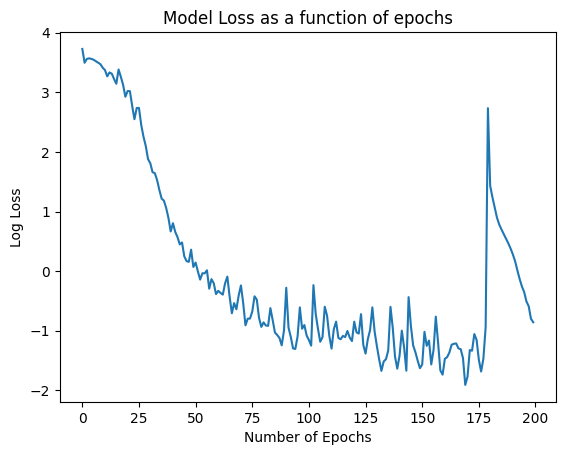

In [52]:
plt.plot(np.log(np.array(loss_list)), label="50")
# plt.plot(np.log(model50), label="50")
# plt.plot(np.log(model16), label="32")
plt.xlabel("Number of Epochs")
plt.ylabel("Log Loss")
plt.title("Model Loss as a function of epochs")
# plt.legend()
plt.show()